In [ ]:
# POPULATION ANALYSIS - TRAINED DATA, no familiarity effect. regulation carries on

# import list
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import main_funcs as mfun
import utils_funcs as utils
import plot_funcs as pfun
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from itertools import compress
import seaborn as sns
import glob as glob

#parameters
fRate = 1000/30.0
pre_frames    = 2000.0# in ms
pre_frames    = int(np.ceil(pre_frames/fRate))
post_frames   = 6000.0 # in ms
post_frames   = int(np.ceil(post_frames/fRate))
analysis_time = 2000.0 # in ms
analysis_time = int(np.ceil(analysis_time/fRate))
simulationDur_ms = 350.0 # in ms
simulationDur = int(np.ceil(simulationDur_ms/fRate))

#paths

savefigpath  = 'C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\figs\\'
analysispath = 'C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\analysis\\'

responsiveSensory, responsiveNoSensory = mfun.selectInterestedcells ( 'CTAP',  'Trained', responsive = True, plotValues = False, pupil = False )

# load data

infoPath = 'C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\analysis\\infoForAnalysis-readyForPlotting.pkl'
dff_traceBoth, dff_traceVis, dff_traceOpto, dff_meanBoth1sec, dff_meanVis1sec, dff_meanOpto1sec  = pd.read_pickle(infoPath) 
print('Sensory responsive cell number:'+ str(np.sum(responsiveSensory)))

In [ ]:
# Plot the heat map for all responsive cells

yminValue = -0.75
ymaxValue = 0.75


# HEAT PLOT FOR RESPONSIVE SENSORY CELLS
index = responsiveSensory
sortedInd = np.array(dff_meanVis1sec[index]).argsort()

plt.subplot(1,3,1)
plot_data = dff_traceVis[index]
plot_data = plot_data[sortedInd]
x_labels = np.linspace(-2, 6, plot_data.shape[1], dtype = int)
step = 30
xticks = np.arange(0, len(x_labels), step)
xticklabels = x_labels[::step]
ax = sns.heatmap(plot_data, vmin = yminValue, vmax = ymaxValue, cbar = False, yticklabels = False)
plt.xticks (ticks = xticks, labels= xticklabels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plot_dataV = plot_data
plt.xlim(30,240)
plt.xlabel('Time (sec)')
plt.ylabel('Cells')
plt.title('Visual')

plt.subplot(1,3,2)
plot_data = dff_traceBoth[index]
plot_data = plot_data[sortedInd]
ax = sns.heatmap(plot_data, vmin = yminValue, vmax = ymaxValue, cbar = False, yticklabels = False)
plt.xticks (ticks = xticks, labels= xticklabels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plot_dataB = plot_data
plt.xlim(30,240)
plt.xlabel('Time (sec)')
plt.title('Visual + Opto')

plt.subplot(1,3,3)
#sortedInd = np.array(dff_meanBoth1sec[index]).argsort()
plot_data = plot_dataB - plot_dataV

ax = sns.heatmap(plot_data, vmin = yminValue, vmax = ymaxValue, cbar = True, yticklabels = False,
                  cbar_kws={'label': 'dFF'})
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.xticks (ticks = xticks, labels= xticklabels)
plot_diff = plot_data
plt.xlim(30,240)
plt.xlabel('Time (sec)')
plt.title('Opto modulations')

pfun.save_figure( 'Figure3_Heat-map_SensoryResponsive-AllComparison',savefigpath)

In [ ]:
# Plot the histograms

plot_dataVmean = np.nanmean(plot_dataV [:, pre_frames:(pre_frames + simulationDur + analysis_time)], axis = 1)
plot_dataBmean = np.nanmean(plot_dataB [:, pre_frames:(pre_frames + simulationDur + analysis_time)], axis = 1)
pfun.set_figure()
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 3))

plt.subplot(1,3,1)
sns.histplot(plot_dataVmean, binwidth = 0.04, color = 'black')
plt.title('Visual')
plt.xlim(-1, 1)
plt.ylim(0, 90)
plt.ylabel('Number of cells')
plt.xlabel('DFF')
plt.subplot(1,3,2)
sns.histplot(plot_dataBmean, binwidth = 0.04, color = 'red',)
plt.title('Visual + Opto')
plt.xlim(-1, 1)
plt.ylim(0, 90)
plt.ylabel('Number of cells')
plt.xlabel('DFF')
plt.subplot(1,3,3)
sns.histplot(plot_dataBmean-plot_dataVmean, binwidth = 0.04, color = 'darkred')
plt.title('Opto modulations')
plt.xlim(-1, 1)
plt.ylim(0, 90)
plt.ylabel('Number of cells')
plt.xlabel('DFF')

pfun.save_figure( 'Figure3_Histogram_SensoryResponsive-AllComparison',savefigpath)

In [ ]:
# Correlation plot for magnitude in change
# If it was a higher magnitude of response, is it larger change? 

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 4))
plt.subplots_adjust( hspace = 0.8, wspace = 0.6)
colors = ['grey', 'red']
pfun.set_figure()

plot_dataVmean = np.nanmean(plot_dataV [:, pre_frames:(pre_frames + simulationDur + analysis_time)], axis = 1)
plot_dataBmean = np.nanmean(plot_dataB [:, pre_frames:(pre_frames + simulationDur + analysis_time)], axis = 1)

plt.subplot(1,3,1)
index = np.where((2>plot_dataVmean) &(plot_dataVmean>0))[0]
plot_data = pd.DataFrame( {'Mean DFF' :np.concatenate((plot_dataVmean[index], plot_dataBmean[index])), 
                              'Type':  np.concatenate((np.repeat('Visual', len(plot_dataVmean[index])), np.repeat('Visual+Opto', len(plot_dataBmean[index]))))})
sns.violinplot(x = 'Type', y = 'Mean DFF', data = plot_data, palette=colors,  showfliers = False)
plt.axhline(y = 0, color = 'black', linestyle = '--', linewidth = 0.5)
plt.annotate('p = {:.5f}'.format(stats.ttest_ind(plot_dataVmean[index], plot_dataBmean[index])[1], 3), xy=(0.5, 1.4), xytext=(0, 0), textcoords='offset points', 
             ha = 'center', va = 'top', fontsize=12)
print(stats.ttest_ind(plot_dataVmean[index], plot_dataBmean[index])[1])
plt.ylim(-0.5,1.5)
plt.ylabel('Average DFF > 0')

plt.subplot(1,3,2)
index = np.where((0>plot_dataVmean) &(plot_dataVmean>-2))[0]
plot_data= pd.DataFrame( {'Mean DFF' :np.concatenate((plot_dataVmean[index], plot_dataBmean[index])), 
                              'Type':  np.concatenate((np.repeat('Visual', len(plot_dataVmean[index])), np.repeat('Visual+Opto', len(plot_dataBmean[index]))))})

sns.violinplot(x = 'Type', y = 'Mean DFF', data = plot_data, palette=colors, showfliers = False)
plt.axhline(y = 0, color = 'black', linestyle = '--', linewidth = 0.5)
plt.annotate('p = {:.5f}'.format(stats.ttest_ind(plot_dataVmean[index], plot_dataBmean[index])[1], 3), xy=(0.5, 0.6), xytext=(0, 0), textcoords='offset points', 
             ha = 'center', va = 'top', fontsize=12)
plt.ylabel('Average DFF < 0')


plt.subplot(1,3,3)

plot_dataVmean = np.nanmax(plot_dataV [:, pre_frames:(pre_frames + simulationDur + analysis_time)], axis = 1)
plot_dataBmean = np.nanmax(plot_dataB [:, pre_frames:(pre_frames + simulationDur + analysis_time)], axis = 1)
plot_diff = np.abs(plot_dataBmean - plot_dataVmean)
plot_dataVmean = np.nanmax(np.abs(plot_dataV [:, pre_frames:(pre_frames + simulationDur + analysis_time)]), axis = 1)
plot_data = pd.DataFrame( {'|Visual| (dFF)' :plot_dataVmean, 
                           '|Visual + Opto| (dFF)':  plot_diff})
sns.scatterplot (y = '|Visual| (dFF)', x = '|Visual + Opto| (dFF)', data = plot_data, color='black')
plt.ylim(0,2.3)
plt.xlim(0,2.3)
axs[2].set_aspect('equal')


pfun.save_figure( 'Figure3_Violin_SensoryResponsive-AllComparison',savefigpath)

In [ ]:
# BEHAVIOR: Sample animal plot
infoPath = 'C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\analysis\\infoForAnalysis-extracted.pkl'
info = pd.read_pickle(infoPath) 

animalID = info.recordingList.animalID
stimuliID = info.recordingList.stimuliFamiliarity
# recordingDate = info.recordingList.recordingDate
# recordingDate[indList]
s_animalID = 22107
s_stimuliID = 5 # For training sessions 
indList = np.where((np.array(animalID) == s_animalID) & (np.array(stimuliID) == s_stimuliID ))
indList = indList[0]
if s_animalID == 22101:
    indList = indList[:-2]
elif s_animalID == 22102:
    indList = indList[:-3]
fRate = 20000

    
# Create behaviour sessions plots
animal_lick  =[]
animal_water =[]
for ind in (indList):
    savepathname = info.recordingList.analysispathname[ind]
    pathname = [f for f in glob.glob(savepathname + 'training-paq-data.pkl')]
    paqData = pd.read_pickle (pathname[0])
    # Get the stim start times 
    trialStartTimes = utils.paq_data (paqData, 'maskerLED', 1, threshold_ttl=True)

    trialStartTimes = trialStartTimes - (2*fRate)

    if len(trialStartTimes)<500:
        licks, trial_licks = utils.lick_binner(savepathname, trialStartTimes,'lickDetection', stimulation = False)
        waterPoints, trial_water = utils.lick_binner(savepathname,trialStartTimes, 'waterDelivery', stimulation = False)

        animal_lick = animal_lick + trial_licks
        animal_water = animal_water + trial_water

fig = plt.figure(str(ind))
for i, array in enumerate(animal_lick):
    plt.plot(array, np.ones_like(array)+i, 'k.',markersize = 1)
    plt.plot(animal_water[i], np.ones_like(animal_water[i])+i+0.3, 'bo',markersize = 2)
                
plt.xlim(0, 8*fRate)
ymax = 900

plt. ylim(0, ymax)
plt.yticks(range(0,ymax, 150), range(ymax,0, -150))
plt.xticks (range(0,(8*fRate)+1,fRate), range(-2,7,1))
plt.ylabel('Trials')
plt.xlabel('Time (sec)')
plt.title(str(s_animalID))
savepathname = 'C:\\Users\\Huriye\Documents\\code\\clapfcstimulation\\figs\\'
pfun.save_figure( 'Figure3_ExampleAnimalBeh',savepathname)
plt.close(fig)


22101
(array([183, 190, 197, 205, 212, 220, 225, 230, 237, 245, 253, 260],
      dtype=int64),)
183
C:\Users\Huriye\Documents\code\clapfcstimulation\analysis\2022-05-07_22101_001\
['C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\analysis\\2022-05-07_22101_001\\training-paq-data.pkl']
190
C:\Users\Huriye\Documents\code\clapfcstimulation\analysis\2022-05-06_22101_001\
['C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\analysis\\2022-05-06_22101_001\\training-paq-data.pkl']
237
C:\Users\Huriye\Documents\code\clapfcstimulation\analysis\2022-04-25_22101_001\
['C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\analysis\\2022-04-25_22101_001\\training-paq-data.pkl']
245
C:\Users\Huriye\Documents\code\clapfcstimulation\analysis\2022-04-24_22101_001\
['C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\analysis\\2022-04-24_22101_001\\training-paq-data.pkl']
22103
(array([185, 192, 199, 207, 214, 222, 227, 232, 239, 247, 255], dtype=int64),)
199
C:\Users\Huriye\Documents\c

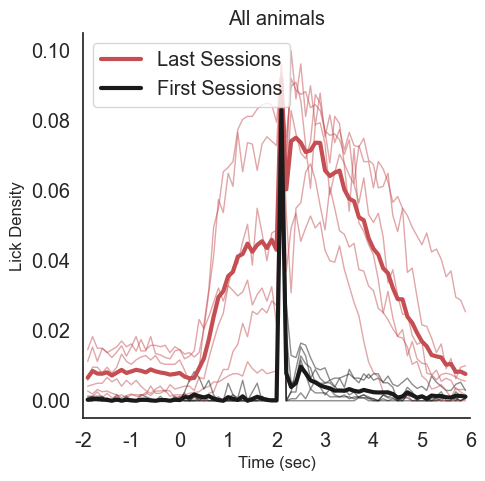

In [20]:
# BEHAVIOR: Average lick plot during learning
    
# BEHAVUIOR SAMPLE TRAINED ANIMAL
infoPath = 'C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\analysis\\infoForAnalysis-extracted.pkl'
info = pd.read_pickle(infoPath) 

animalID = info.recordingList.animalID
stimuliID = info.recordingList.stimuliFamiliarity
    
animalList = [22101, 22103, 22104, 22105, 22106, 22107]
fRate = 20000
s_stimuliID = 5 # For training sessions
types = ['Last Sessions', 'First Sessions']

fig = plt.figure()
pfun.set_figure()

# Create behaviour sessions plots
for s_animalID in animalList: 
    print(s_animalID)
    indList = np.where((np.array(animalID) == s_animalID) & (np.array(stimuliID) == s_stimuliID ))
    indListAll = indList[0]
    print(indList)
    if s_animalID == 22101:
        indListAll = indListAll[:-2]
    elif s_animalID == 22102:
        indListAll = indListAll[:-3]
    elif s_animalID == 22103:
        indListAll = indListAll[2:]
    
    for type in types:
        if type == 'Last Sessions':
            indList = indListAll[:2]
            colorV = 'r'
        elif type == 'First Sessions':
            indList = indListAll[-2:]
            colorV = 'k'
        animal_lick  =[]
        animal_water =[]
        for ind in (indList):
            print(ind)
            savepathname = info.recordingList.analysispathname[ind]
            print(savepathname)
            pathname = [f for f in glob.glob(savepathname + 'training-paq-data.pkl')]
            print(pathname)
            paqData = pd.read_pickle (pathname[0])
            # Get the stim start times 
            trialStartTimes = utils.paq_data (paqData, 'maskerLED', 1, threshold_ttl=True)

            trialStartTimes = trialStartTimes - (2*fRate)

            if len(trialStartTimes)<500:
                licks, trial_licks = utils.lick_binner(savepathname, trialStartTimes,'lickDetection', stimulation=False)
                animal_lick = animal_lick + trial_licks
        
        bin_width = 10  # Adjust this value to change the width of each bin
        num_bins = range(0, 8*fRate, int(fRate/bin_width))
       
        animal_hist = np.zeros(len(num_bins)-1)
        for i, array in enumerate(animal_lick):
            hist, bins = np.histogram(array, bins=num_bins, range=(0, 8*fRate))
            animal_hist = animal_hist + hist
        animal_hist = animal_hist/ (i+1)/bin_width
        plt.plot( bins[1:],animal_hist, colorV, linewidth =1, alpha= 0.5)

        if type == 'First Sessions':
            if s_animalID == 22101:
                animal_hist_FirstAll = animal_hist
            else:
                animal_hist_FirstAll = np.vstack((animal_hist_FirstAll,animal_hist))
        else:
            if s_animalID == 22101:
                animal_hist_LastAll = animal_hist
            else:
                animal_hist_LastAll = np.vstack((animal_hist_LastAll,animal_hist))

plt.plot( bins[1:],np.mean(animal_hist_LastAll,0 ), 'r', linewidth =3, alpha= 1, label = 'Last Sessions')
plt.plot( bins[1:],np.mean(animal_hist_FirstAll,0), 'k', linewidth =3, alpha= 1, label = 'First Sessions')
plt.legend()
plt.xlim(0, 8*fRate)
plt.xticks (range(0,(8*fRate)+1,fRate), range(-2,7,1))
plt.ylabel('Lick Density')
plt.xlabel('Time (sec)')
plt.title('All animals')
savepathname = 'C:\\Users\\Huriye\Documents\\code\\clapfcstimulation\\figs\\'
pfun.save_figure( 'Figure3_AverageLickDensity',savepathname)
#plt.close(fig)



177
C:\Users\Huriye\Documents\code\clapfcstimulation\analysis\2022-05-09_22101_001\
['optoStimTimes how many?:5120']
optoStimTimes how many?:64
trialStartTimes how many?:90
(array([ 0,  1,  2,  3,  5,  6,  7,  9, 11, 14, 16, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 30, 31, 32, 33, 34, 35, 37, 38, 40, 41, 42, 43, 45,
       47, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 66, 68,
       70, 72, 73, 76, 78, 80, 81, 82, 83, 84, 86, 87, 88], dtype=int64),)
1
179
C:\Users\Huriye\Documents\code\clapfcstimulation\analysis\2022-05-09_22104_001\
['optoStimTimes how many?:5120']
optoStimTimes how many?:64
trialStartTimes how many?:90
(array([ 0,  1,  2,  3,  5,  6,  7,  9, 11, 14, 16, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 30, 31, 32, 33, 34, 35, 37, 38, 40, 41, 42, 43, 45,
       47, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 66, 68,
       70, 72, 73, 76, 78, 80, 81, 82, 83, 84, 86, 87, 88], dtype=int64),)
1
181
C:\Users\Huriye\Documents\code\clapfcstimula

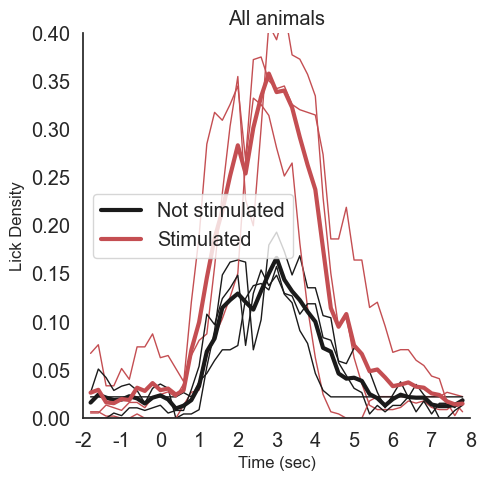

In [19]:
# BEHAVIOR: Average lick plot for cue stimulated sessions 
    
# BEHAVUIOR SAMPLE TRAINED ANIMAL
infoPath = 'C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\analysis\\infoForAnalysis-extracted.pkl'
info = pd.read_pickle(infoPath) 

animalID = info.recordingList.animalID
stimuliID = info.recordingList.stimuliFamiliarity
    
animalList = [22101,22104,22107]
fRate = 20000
s_stimuliID =  4# For cue stimulated session
types = ['Stimulated', 'Not stimulated']
duration = 10 # second -2 to 8 sec
bin_width = 5# Adjust this value to change the width of each bin

#fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 4))
pfun.set_figure()


# Create behaviour sessions plots
for s_animalID in animalList: 
    ind = np.where((np.array(animalID) == s_animalID) & (np.array(stimuliID) == s_stimuliID ))
    ind = ind[0][0]
    print(ind)

    savepathname = info.recordingList.analysispathname[ind]
    print(savepathname)
    pathname = [f for f in glob.glob(savepathname + 'paq-data.pkl')]
    paqData = pd.read_pickle (pathname[0])
    # Get the stim start times 
    trialStartTimes = utils.paq_data (paqData, 'maskerLED', 1, threshold_ttl=True)
    optoStimTimes = utils.paq_data (paqData, 'optoLoopback', 1, threshold_ttl=True)
    print(['optoStimTimes how many?:' + str(len(optoStimTimes))])
    # Clean the triggers from stimulation frequencies
    first_ind = np.where(np.diff(optoStimTimes)>1*fRate)
    first_ind = np.concatenate(([0], first_ind[0]+1))
    optoStimTimes = np.array(optoStimTimes)
    optoStimTimes = optoStimTimes[first_ind]
    if s_stimuliID ==4:
        optoStimTimes = optoStimTimes - (2*fRate)
    elif s_stimuliID ==3:
        if s_animalID ==22101:
            optoStimTimes = optoStimTimes -1
        else:
            optoStimTimes = optoStimTimes

    print('optoStimTimes how many?:' + str(len(optoStimTimes)))
    print('trialStartTimes how many?:' + str(len(trialStartTimes)))
    if s_animalID ==22107:
        trialStartTimes = trialStartTimes[1:75]
    common_indices = np.where(np.isin(trialStartTimes, np.intersect1d(trialStartTimes, optoStimTimes)))
    print(common_indices)
    not_common_indices = np.where(np.isin(trialStartTimes, np.setdiff1d(trialStartTimes, optoStimTimes)))
    print(len(not_common_indices))

    trialStartTimes = trialStartTimes - (2*fRate)
    

    licks, trial_licks = utils.lick_binner(savepathname, trialStartTimes,'lickDetection')
    animal_lick = trial_licks


    num_bins = range(0, duration*fRate, int(fRate/bin_width))
       
    animal_hist = np.zeros(len(num_bins)-1)
    for i in np.nditer(common_indices):
        array = animal_lick[i]
        hist, bins = np.histogram(array, bins=num_bins, range=(0, duration*fRate))
        animal_hist = animal_hist + hist
    animal_hist = animal_hist/(i+1)/bin_width
    plt.plot( bins[1:],animal_hist, 'r', linewidth =1)

    if s_animalID == 22101:
        animal_hist_FirstAll = animal_hist
    else:
        animal_hist_FirstAll = np.vstack((animal_hist_FirstAll,animal_hist))

    animal_hist = np.zeros(len(num_bins)-1)
    for i in np.nditer(not_common_indices):
        array = animal_lick[i]
        hist, bins = np.histogram(array, bins=num_bins, range=(0, duration*fRate))
        animal_hist = animal_hist + hist
    animal_hist = animal_hist/ (i+1)/bin_width
    plt.plot( bins[1:],animal_hist, 'k', linewidth =1)

    if s_animalID == 22101:
        animal_hist_LastAll = animal_hist
    else:
        animal_hist_LastAll = np.vstack((animal_hist_LastAll,animal_hist))

plt.plot( bins[1:],np.mean(animal_hist_LastAll,0 ), 'k', linewidth =3, alpha= 1, label = 'Not stimulated')
plt.plot( bins[1:],np.mean(animal_hist_FirstAll,0), 'r', linewidth =3, alpha= 1, label = 'Stimulated')
plt.legend()
plt.xlim(0, duration*fRate)
plt.xticks (range(0,(duration*fRate)+1,fRate), range(-2,duration-1,1))
plt.ylabel('Lick Density')
plt.xlabel('Time (sec)')
plt.title('All animals')
plt.ylim(0, 0.4)

savepathname = 'C:\\Users\\Huriye\Documents\\code\\clapfcstimulation\\figs\\'
pfun.save_figure( 'Figure3_AverageLickDensity-CueStimulation',savepathname)
plt.close(fig)
        

